In [433]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import string
import seaborn as sns

import scipy as sp
from scipy import sparse
import sklearn
import umap
from sklearn.neighbors import NearestNeighbors


## add your packages ##

import time
import pickle
import memory_profiler

%load_ext memory_profiler

from pathlib import Path

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [434]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [435]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("../data")

In [436]:
plt.style.use("matplotlib_style.txt")

In [437]:
np.random.seed(42)

# Data

We are going to use the multimodal data from the paper Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). In particular, you will work with transcriptomics and electrophysiological data. From the transcriptomics gene counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out for the project.

## Import

### Meta data

In [438]:
# META DATA

meta = pd.read_csv("data/m1_patchseq_meta_data.csv", sep="\t")

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [
        c if c[-1] != "+" and c[-1] != "-" else c[:-1]
        for c in meta["Cre"].values
    ]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [
        np.unique(meta["Date"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse age"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse"].values[sliceids == s]).size == 1
        for s in sliceids
    ]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


### Transcriptomic data

In [439]:
# READ COUNTS

data_exons = pd.read_csv(
    "data/m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
exonCounts = data_exons.values.transpose()

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

print("Count matrix shape (exon):  ", exonCounts.shape)

Count matrix shape (exon):   (1329, 42466)


In [440]:
data_exons

20171204_sample_2  20171204_sample_4  20171204_sample_5  \
0610005C13Rik                  0                  0                  0   
0610006L08Rik                  0                  0                  0   
0610009B22Rik                  0                 68               1291   
0610009E02Rik                  0                  0                  0   
0610009L18Rik                  0                  0                  0   
...                          ...                ...                ...   
n-R5s96                        0                  0                  0   
n-R5s97                        0                  0                  0   
n-R5s98                        0                  0                  0   
n-TSaga9                       0                  0                  0   
n-TStga1                       0                  0                  0   

               20171204_sample_6  20171207_sample_1  20171207_sample_2  \
0610005C13Rik                  0                  0                  1   
0610006L08Rik                  0                  0                 13   
0610009B22Rik                  0                  0                  0   
0610009E02Rik                  0                 30                 80   
0610009L18Rik                  0                  0                 99   
...                          ...                ...                ...   
n-R5s96                        0                  0                  0   
n-R5s97                        0                  0                  0   
n-R5s98                        0                  0                  0   
n-TSaga9                       0                  0                  0   
n-TStga1                       0                  0                  0   

               20171207_sample_6  20171207_sample_7  20171219_sample_1  \
0610005C13Rik                  0                  0                  0   
0610006L08Rik                  0                  0                  0   
0610009B22Rik                227                  0                  7   
0610009E02Rik                205                  0                  0   
0610009L18Rik                  0                380                  0   
...                          ...                ...                ...   
n-R5s96                        0                  0                  0   
n-R5s97                        0                  0                  0   
n-R5s98                        0                  0                  0   
n-TSaga9                       0                  0                  0   
n-TStga1                       0                  0                  0   

               20171219_sample_2  ...  20191114_sample_9  20200106_sample_1  \
0610005C13Rik                  0  ...                  0                  0   
0610006L08Rik                  0  ...                  0                  0   
0610009B22Rik                 10  ...                  0                271   
0610009E02Rik                 14  ...                  0                  0   
0610009L18Rik                  0  ...                  0                  0   
...                          ...  ...                ...                ...   
n-R5s96                        0  ...                  0                  0   
n-R5s97                        0  ...                  0                  0   
n-R5s98                        0  ...                  0                  0   
n-TSaga9                       0  ...                  0                  0   
n-TStga1                       0  ...                  0                  0   

               20200106_sample_4  20200106_sample_5  20200106_sample_6  \
0610005C13Rik                  0                  0                  1   
0610006L08Rik                  0                  0                  0   
0610009B22Rik                  0                  0                  0   
0610009E02Rik                  0                  0                  0   
0610009L18Rik                

In [441]:
# GENE LENGTH

data = pd.read_csv("data/gene_lengths.txt")
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values
intronLengths = data["intron_bp"].values

### Cluster colors

In [442]:
cluster_colors = np.load("data/cluster_colors.npy")

In [443]:
cluster_colors.shape

(1329,)

In [444]:
rna_type = np.load("data/rna_type.npy", allow_pickle=True)

In [445]:
rna_type.shape

(1329,)

In [446]:
pickle_in = open("data/dict_rna_type_colors.pkl", "rb")
dict_rna_type_colors = pickle.load(pickle_in)

In [447]:
len(dict_rna_type_colors)

88

### Electrophysiological features

In [448]:
# EPHYS DATA

ephysData = pd.read_csv("data/m1_patchseq_ephys_features.csv")
XYZ = ephysData
print(XYZ)
print(data_exons)
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [
        names2ephys[c] if c in names2ephys else ephysData[0] * np.nan
        for c in cells
    ]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0
print(ephysNames)

                cell id  AP Fano factor  AP amplitude (mV)  \
0     20180918_sample_1        3.711764          75.569041   
1     20180918_sample_2        2.710569          86.732939   
2     20180918_sample_3        0.622750          80.275331   
3     20180917_sample_4        2.795553          60.218537   
4     20180917_sample_1        2.275313          83.007075   
...                 ...             ...                ...   
1323  20200225_sample_2        2.034102          93.913827   
1324  20200225_sample_5        6.912920          91.121625   
1325  20200316_sample_3        1.453443          76.419747   
1326  20200316_sample_2        1.357806          86.354908   
1327  20200316_sample_1        1.383475          89.059263   

      AP amplitude adaptation index  AP amplitude average adaptation index  \
0                          0.899183                               0.975435   
1                          0.763202                               0.953588   
2                    

In [449]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]
features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData
print(X[:, 0].shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
# X = X[:, ~np.isin(ephysNames, features_exclude)]

# keepcells = ~np.isnan(np.sum(X, axis=1))
# X = X[keepcells, :]
# print(X.shape)

# X = X - X.mean(axis=0)
# ephysData_filtered = X / X.std(axis=0)
# print(X)

(1329,)


In [450]:
# np.sum(np.isnan(ephysData_filtered))

# Research questions to investigate

**1) Inspect the data computing different statistics.** Keep in mind that the data is read counts, not UMI, so it is not supposed to follow a Poisson distribution.

**2) Normalize and transform the data.** There are several ways of normalizing the data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization.

**3) Two-dimensional visualization.** Try different methods (t-SNE, UMAP) / parameters (exagg., perplex.) for visualizations. Compare them using quantitative metrics (e.g., distance correlation, kNN accuracy/recall in high-dim vs. two-dim). Think about also using the electrophysiological features for different visualizations.

**4) Clustering.** Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2) and S (set of important genes). Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation in between electrophysiological features and genes/PCs.** Find correlations and a way of visualizing them.
    

### Introduction

## 1) Inspect The Data ##

In [451]:
gene_means = np.mean(exonCounts, axis=0)
gene_medians = np.median(exonCounts, axis=0)
gene_var = np.var(exonCounts, axis=0)

/var/folders/25/9dn0c0fd27d1n54d7q1rqx7c0000gn/T/ipykernel_11306/2458021600.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


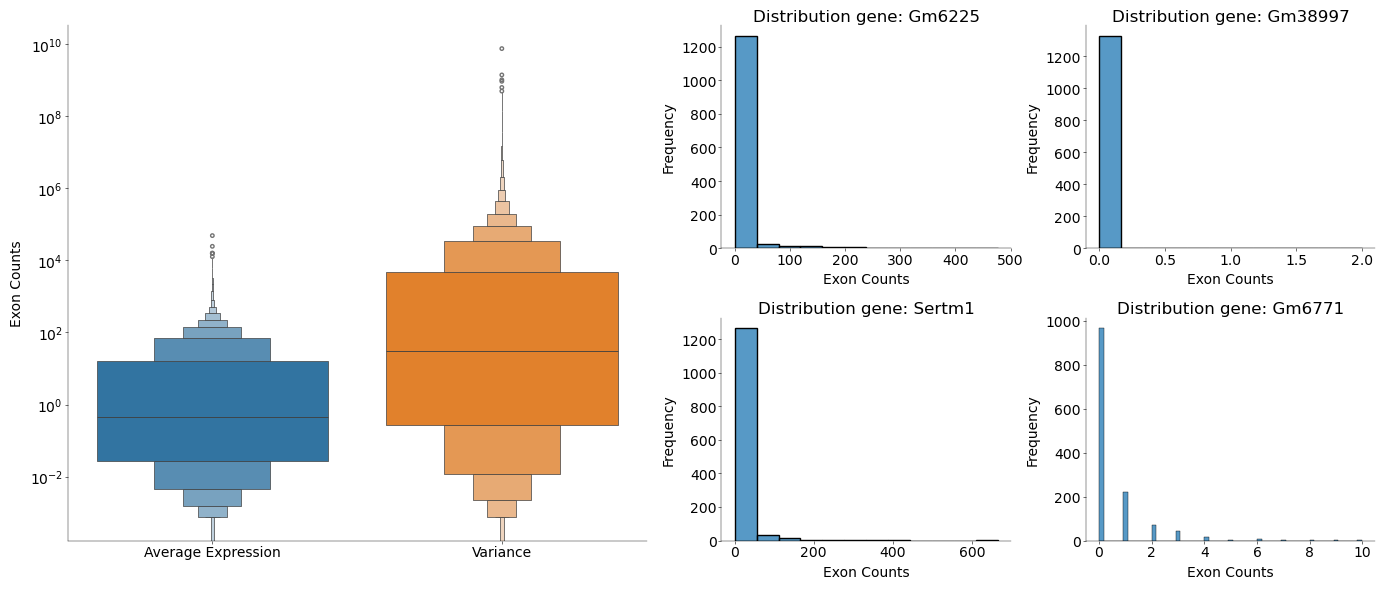

In [452]:
# Define the GridSpec layout
fig = plt.figure(figsize=(14, 6))
gs = plt.GridSpec(2, 3, width_ratios=[2, 1, 1], height_ratios=[1, 1])

ax_main = fig.add_subplot(gs[:, 0])
sns.boxenplot(data=[gene_means, gene_var], ax=ax_main)
ax_main.set_xticks([0, 1])
ax_main.set_xticklabels(["Average Expression", "Variance"])
ax_main.set_ylabel("Exon Counts")
ax_main.set_yscale("log")

np.random.seed(1)
random_genes = np.random.choice(data_exons.index, 4, replace=False)

axes = []
for i in range(2):
    for j in range(1, 3):
        ax = fig.add_subplot(gs[i, j])
        axes.append(ax)

for idx, gene in enumerate(random_genes):
    ax = axes[idx]
    sns.histplot(data_exons.loc[gene], kde=False, ax=ax)
    ax.set_title(f"Distribution gene: {gene}")
    ax.set_xlabel("Exon Counts")
    ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

The plot above shows that there is a high variance in both average expression and variance of each gene. The y-axis is log and the range for the average expression goes from $10^{-3}$ to as high as $10^{5}$. Tgus us even more extrem for the variance. Also the plots on the right, where 4 genes were randomly selected, shows the high variance. Gm38997 has only 0, Gm6771 has up to 10 and Sertm1 has up to 600 (but with the majority having 0). 

## 2) Normalize and Transform the Data ##

In [453]:
def cpm(counts):
    seq_depth = np.sum(counts, axis=1)
    normed = (counts / seq_depth[:, np.newaxis]) * 1e6
    return normed


def cpmedian(counts):
    seq_depth = np.sum(counts, axis=1)
    normed = counts / seq_depth[:, np.newaxis] * np.median(seq_depth)
    return normed


def rpkm(
    counts, lengths
):  ## Taken from https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch01.html
    """Calculate reads per kilobase transcript per million reads.

    RPKM = (10^9 * C) / (N * L)

    Where:
    C = Number of reads mapped to a gene
    N = Total mapped reads in the experiment
    L = Exon length in base pairs for a gene

    Parameters
    ----------
    counts: array, shape (N_genes, N_samples)
        RNAseq (or similar) count data where columns are individual samples
        and rows are genes.
    lengths: array, shape (N_genes,)
        Gene lengths in base pairs in the same order
        as the rows in counts.

    Returns
    -------
    normed : array, shape (N_genes, N_samples)
        The RPKM normalized counts matrix.
    """
    N = np.sum(counts, axis=0)  # sum each column to get total reads per sample
    L = lengths
    C = counts

    normed = 1e9 * C / (N[np.newaxis, :] * L[:, np.newaxis])

    return normed.T


# exonCounts = sklearn.preprocessing.normalize(exonCounts)
cpm = cpm(exonCounts)
cpmedian = cpmedian(exonCounts)
rpkm = rpkm(exonCounts.T, exonLengths)

In [454]:
## Transforms
def sqrt_transform(counts):
    return np.sqrt(counts)


def log_transform(counts):
    return np.log2(counts + 1)

## 3) Two-Dimensional visualization ##

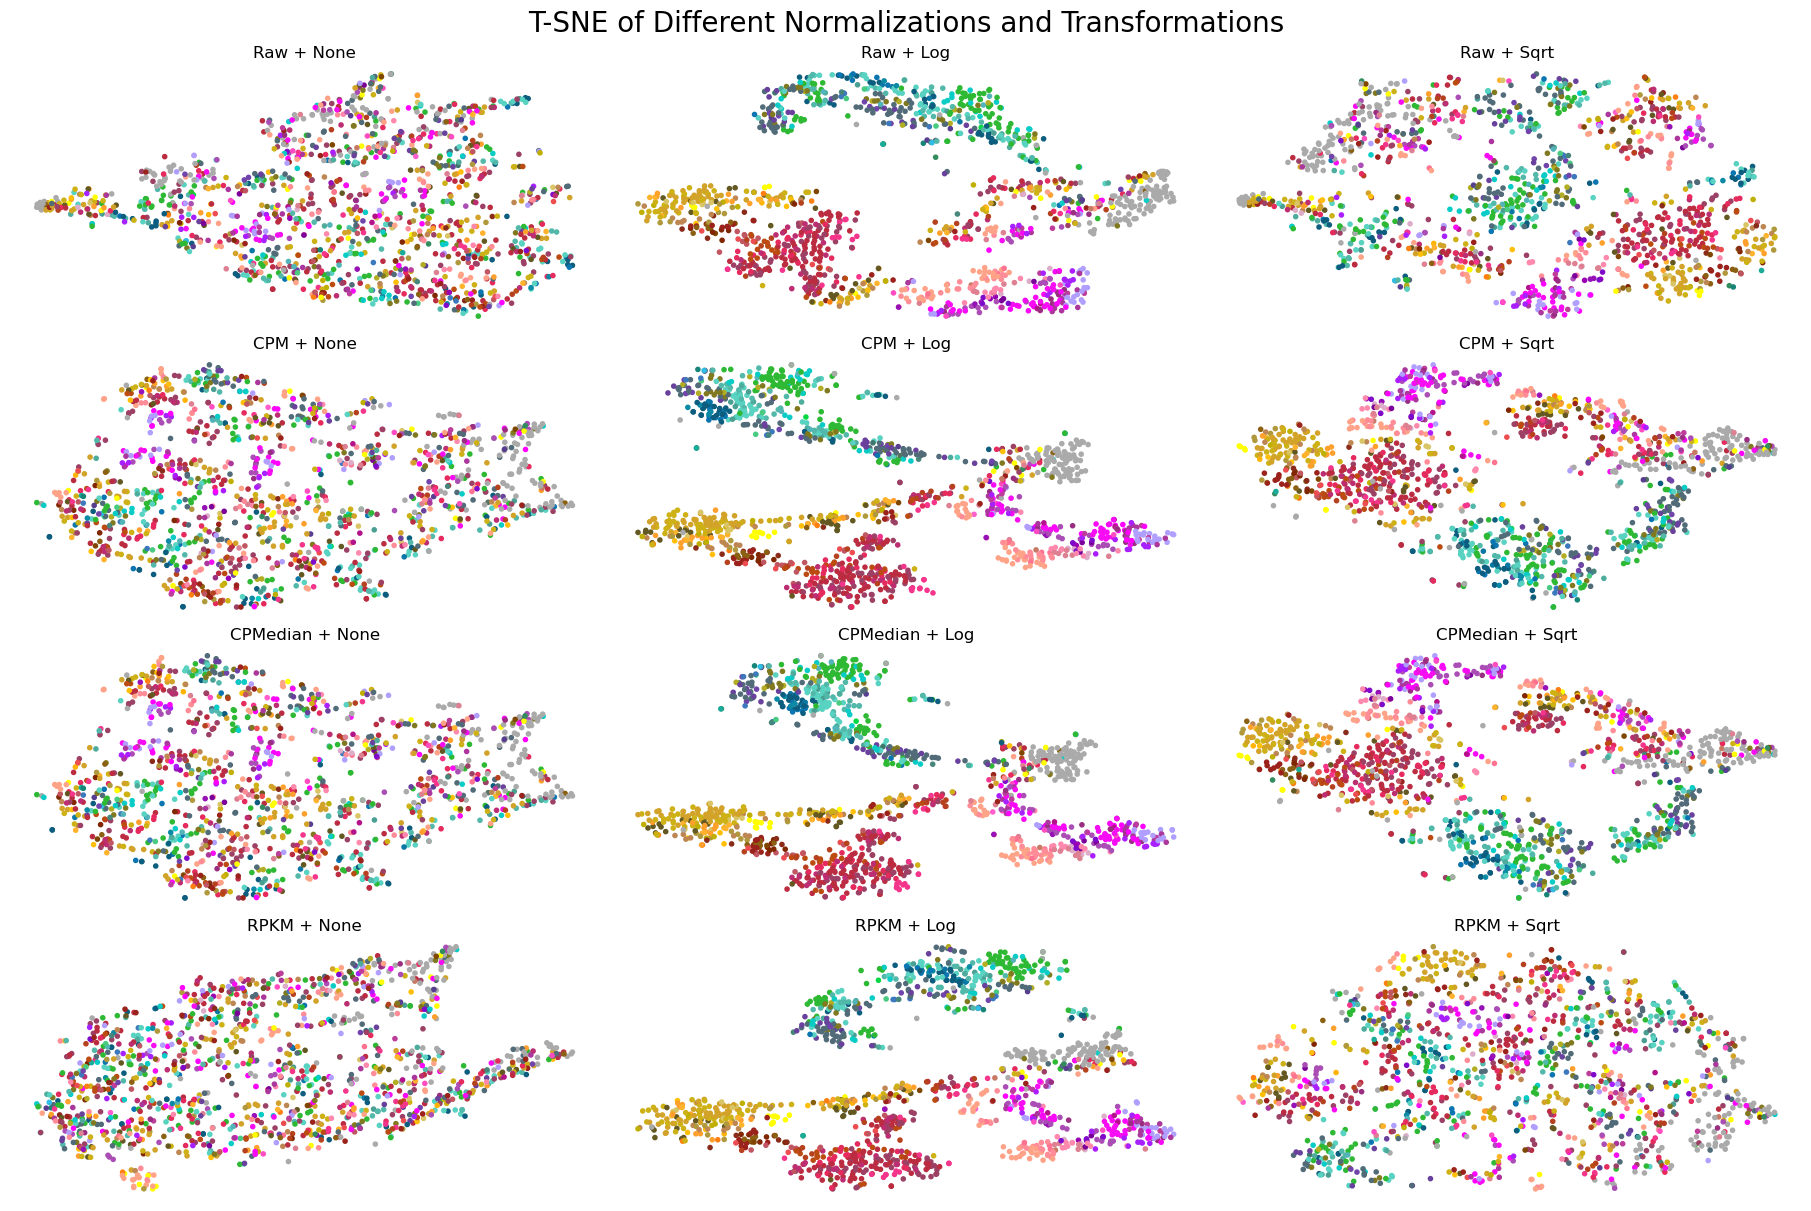

In [455]:
normalizations = {
    "Raw": exonCounts,
    "CPM": cpm,
    "CPMedian": cpmedian,
    "RPKM": rpkm,
}

transformations = {
    "None": lambda x: x,
    "Log": log_transform,
    "Sqrt": sqrt_transform,
}

fig, axes = plt.subplots(
    len(normalizations), len(transformations), figsize=(18, 12)
)
fig.suptitle(
    "T-SNE of Different Normalizations and Transformations", fontsize=20
)


for i, (norm_name, norm_data) in enumerate(normalizations.items()):
    for j, (trans_name, trans_func) in enumerate(transformations.items()):
        data = norm_data[:, gene_var > np.sort(gene_var)[-501]]
        data_transformed = trans_func(data)
        pca_result = sklearn.decomposition.PCA(n_components=50).fit_transform(
            data_transformed
        )
        tsne = sklearn.manifold.TSNE(
            n_components=2, perplexity=30, random_state=7
        )
        tsne_results = tsne.fit_transform(pca_result)

        ax = axes[i, j]
        ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_colors)
        ax.set_title(
            f"{norm_name} + {trans_name}",
            fontsize=12,
        )
        ax.axis("off")
plt.show()

/Users/gulli/miniconda3/envs/Manni/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/gulli/miniconda3/envs/Manni/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/gulli/miniconda3/envs/Manni/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/gulli/miniconda3/envs/Manni/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by

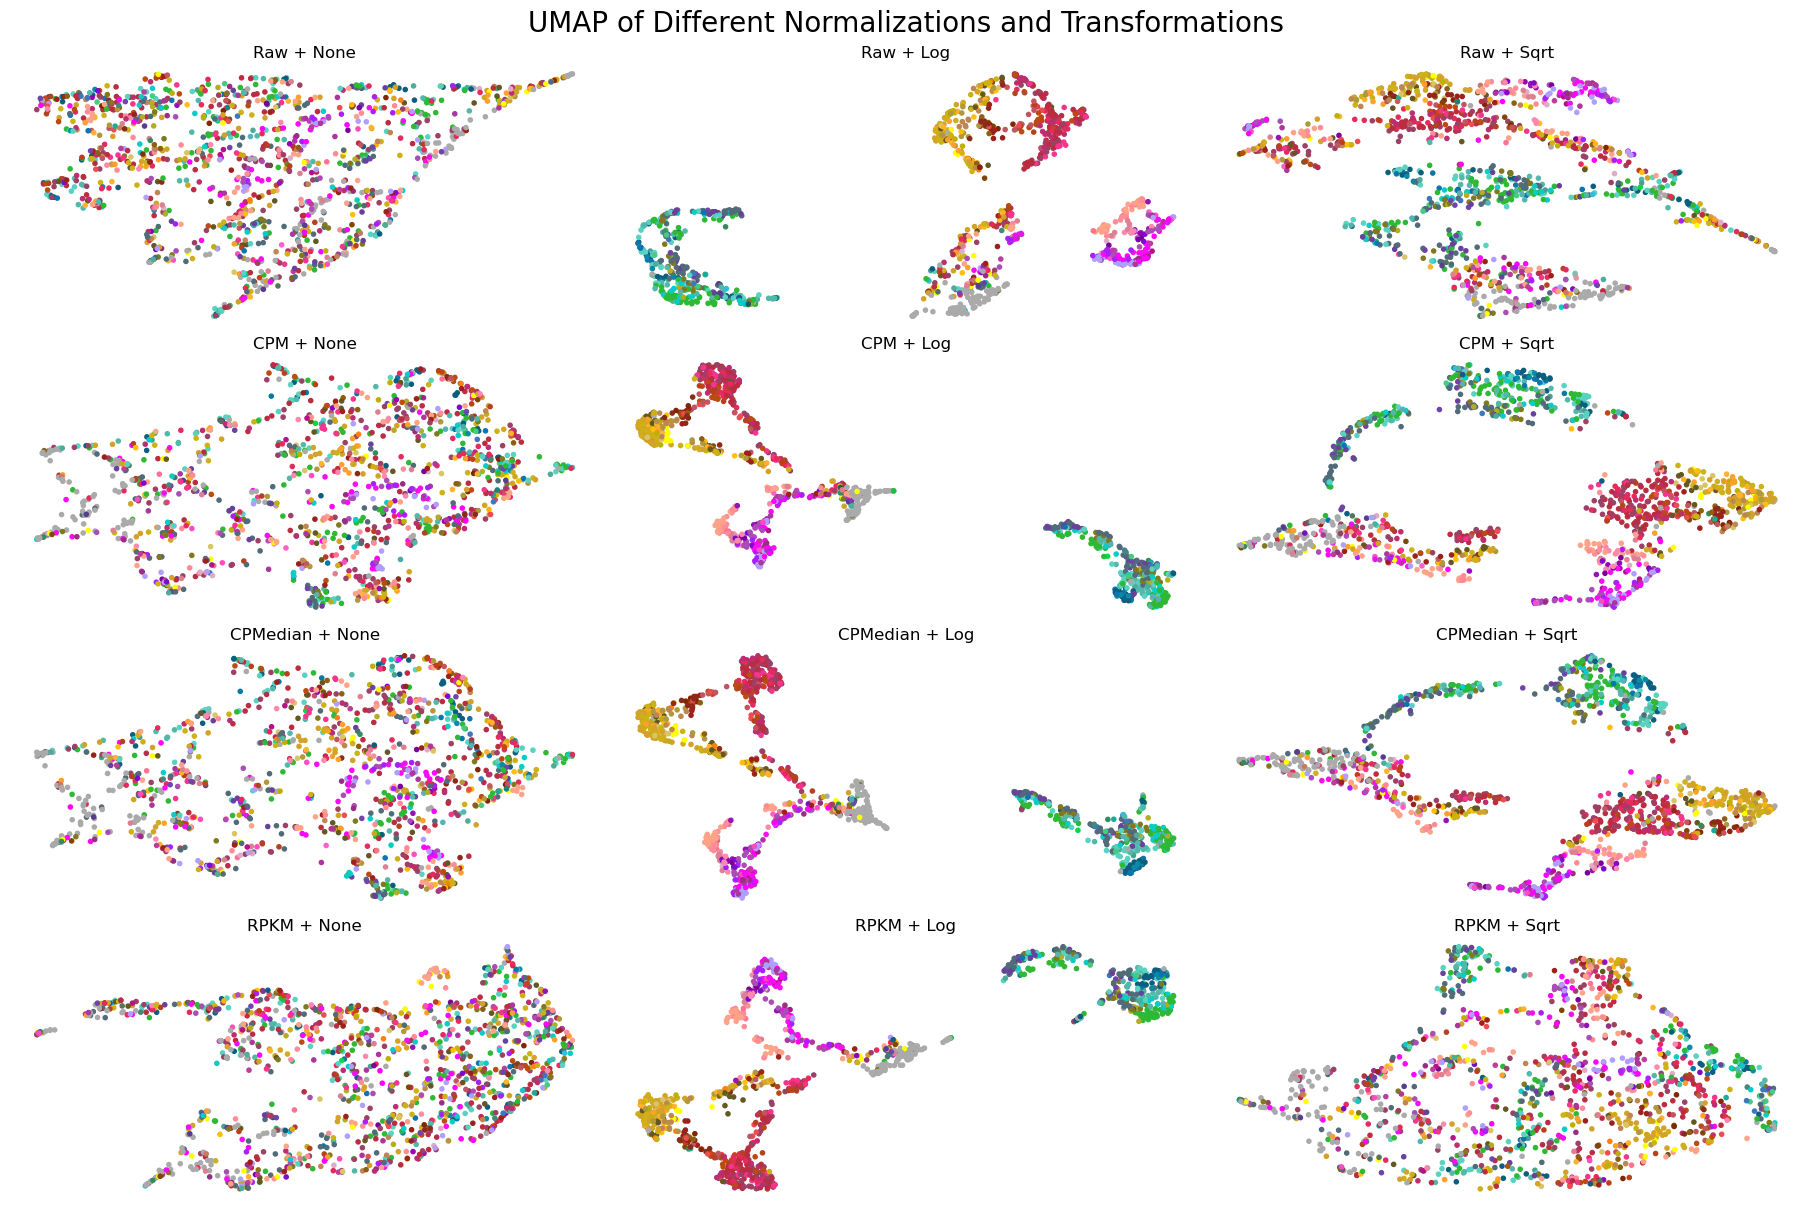

In [456]:
normalizations = {
    "Raw": exonCounts,
    "CPM": cpm,
    "CPMedian": cpmedian,
    "RPKM": rpkm,
}

transformations = {
    "None": lambda x: x,
    "Log": log_transform,
    "Sqrt": sqrt_transform,
}

fig, axes = plt.subplots(
    len(normalizations), len(transformations), figsize=(18, 12)
)
fig.suptitle(
    "UMAP of Different Normalizations and Transformations", fontsize=20
)

for i, (norm_name, norm_data) in enumerate(normalizations.items()):
    for j, (trans_name, trans_func) in enumerate(transformations.items()):
        data = norm_data[:, gene_var > np.sort(gene_var)[-501]]
        data_transformed = trans_func(data)
        pca_result = sklearn.decomposition.PCA(n_components=50).fit_transform(
            data_transformed
        )
        umap_model = umap.UMAP(random_state=7)
        umap_results = umap_model.fit_transform(pca_result)

        ax = axes[i, j]
        scatter = ax.scatter(
            umap_results[:, 0], umap_results[:, 1], c=cluster_colors
        )
        ax.set_title(
            f"{norm_name} + {trans_name}",
            fontsize=12,
        )
        ax.axis("off")

plt.show()

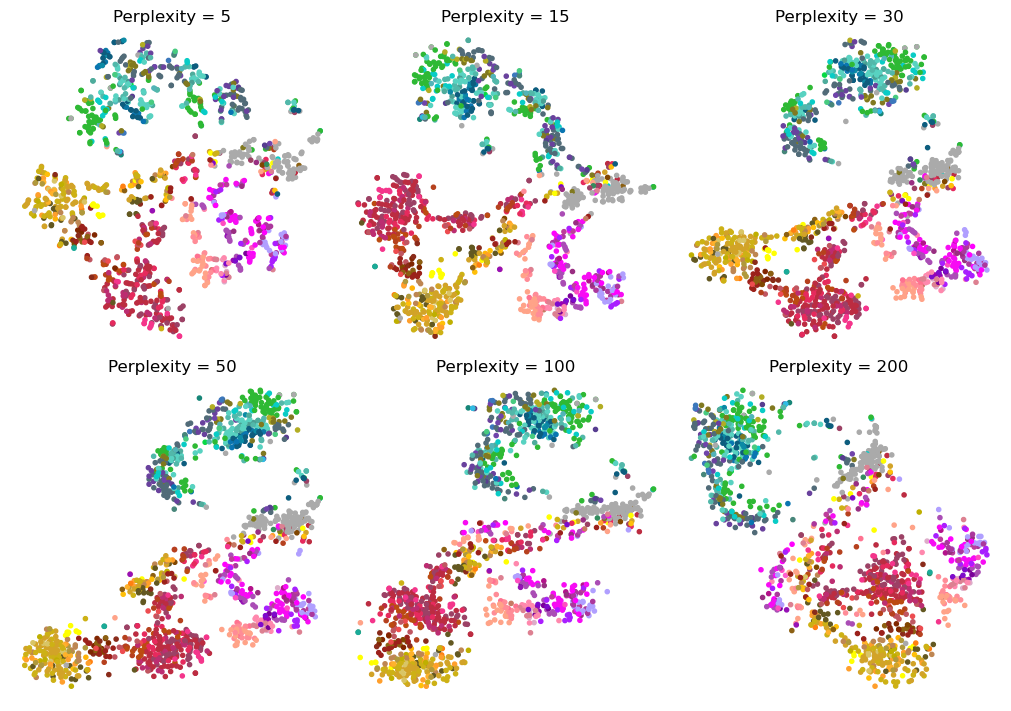

In [457]:
data_final = log_transform(rpkm)
data_final = data_final[:, gene_var > np.sort(gene_var)[-501]]

perplexities = [5, 15, 30, 50, 100, 200]
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
axes_flat = np.ravel(axes)

for idx, perplexity in enumerate(perplexities):
    ax = axes_flat[idx]

    pca_result = sklearn.decomposition.PCA(n_components=50).fit_transform(
        data_final
    )
    tsne = sklearn.manifold.TSNE(
        n_components=2, perplexity=perplexity, random_state=7
    )
    tsne_results = tsne.fit_transform(pca_result)

    ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_colors)
    ax.set_title(
        f"Perplexity = {perplexity}",
        fontsize=12,
    )
    ax.axis("off")

In [458]:
print(X[:, idx])

[-27.95461193 -27.82125399 -26.36340074 ... -36.9925797  -35.3420265
 -46.8021445 ]


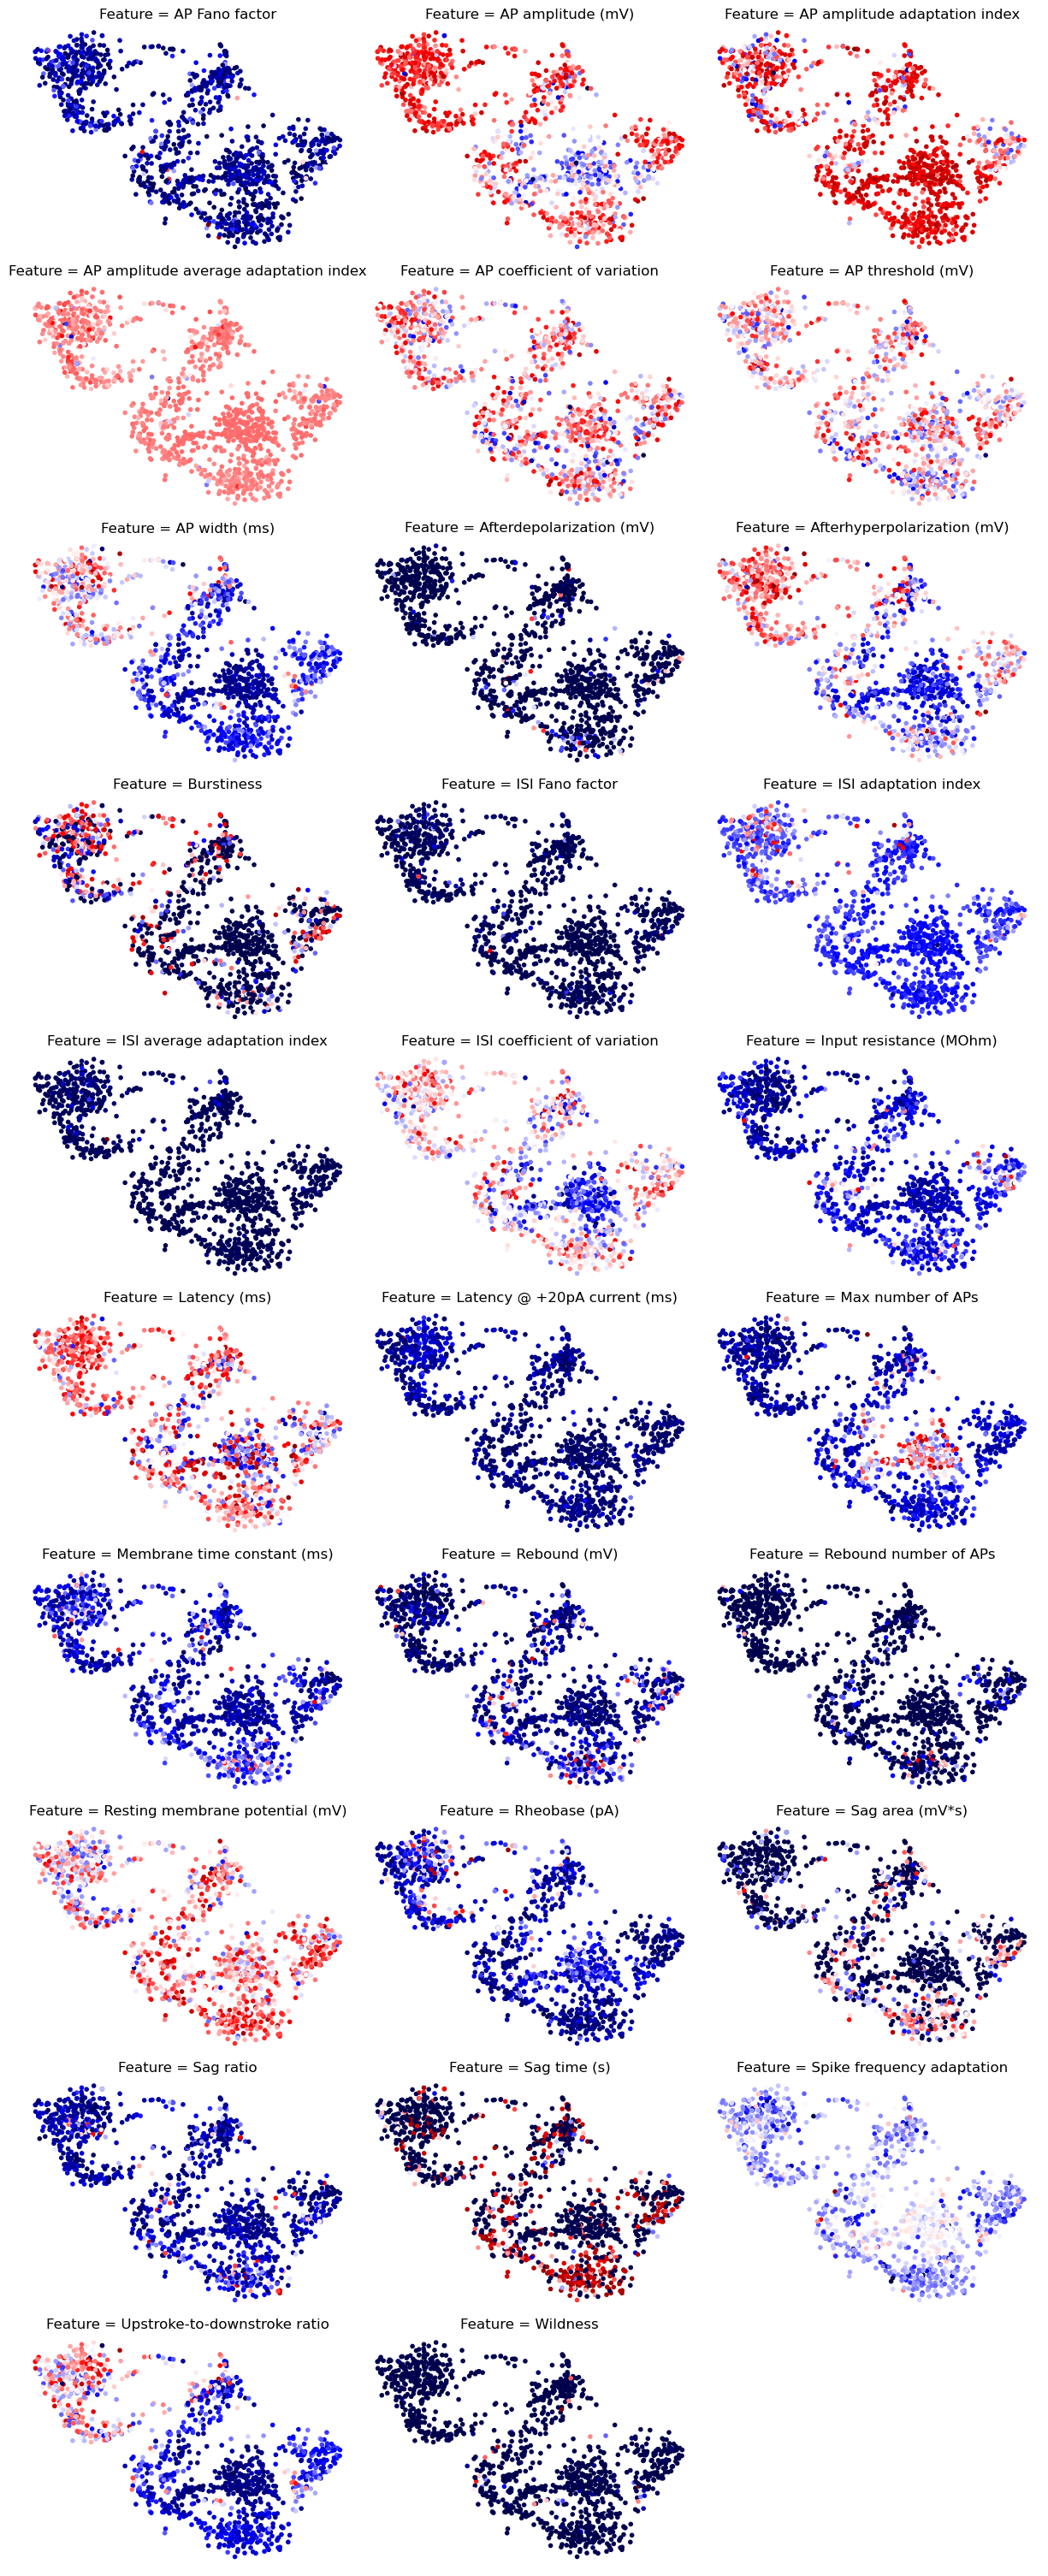

In [459]:
from matplotlib.colors import Normalize

fig, axes = plt.subplots(10, 3, figsize=(12, 30))
axes_flat = np.ravel(axes)
pca_result = sklearn.decomposition.PCA(n_components=50).fit_transform(
    data_final
)
tsne = sklearn.manifold.TSNE(
    n_components=2, perplexity=perplexity, random_state=7
)
tsne_results = tsne.fit_transform(pca_result)


for idx in range(0, len(axes_flat)):
    if idx == 29:
        break
    ax = axes_flat[idx]
    x = X[:, idx]
    norm = Normalize(vmin=min(x), vmax=max(x))
    colors = plt.cm.seismic(norm(x))

    ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors)
    ax.set_title(
        f"Feature = {ephysNames[idx]}",
        fontsize=12,
    )
    ax.axis("off")
axes_flat[29].axis("off")
plt.show()

/Users/gulli/miniconda3/envs/Manni/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


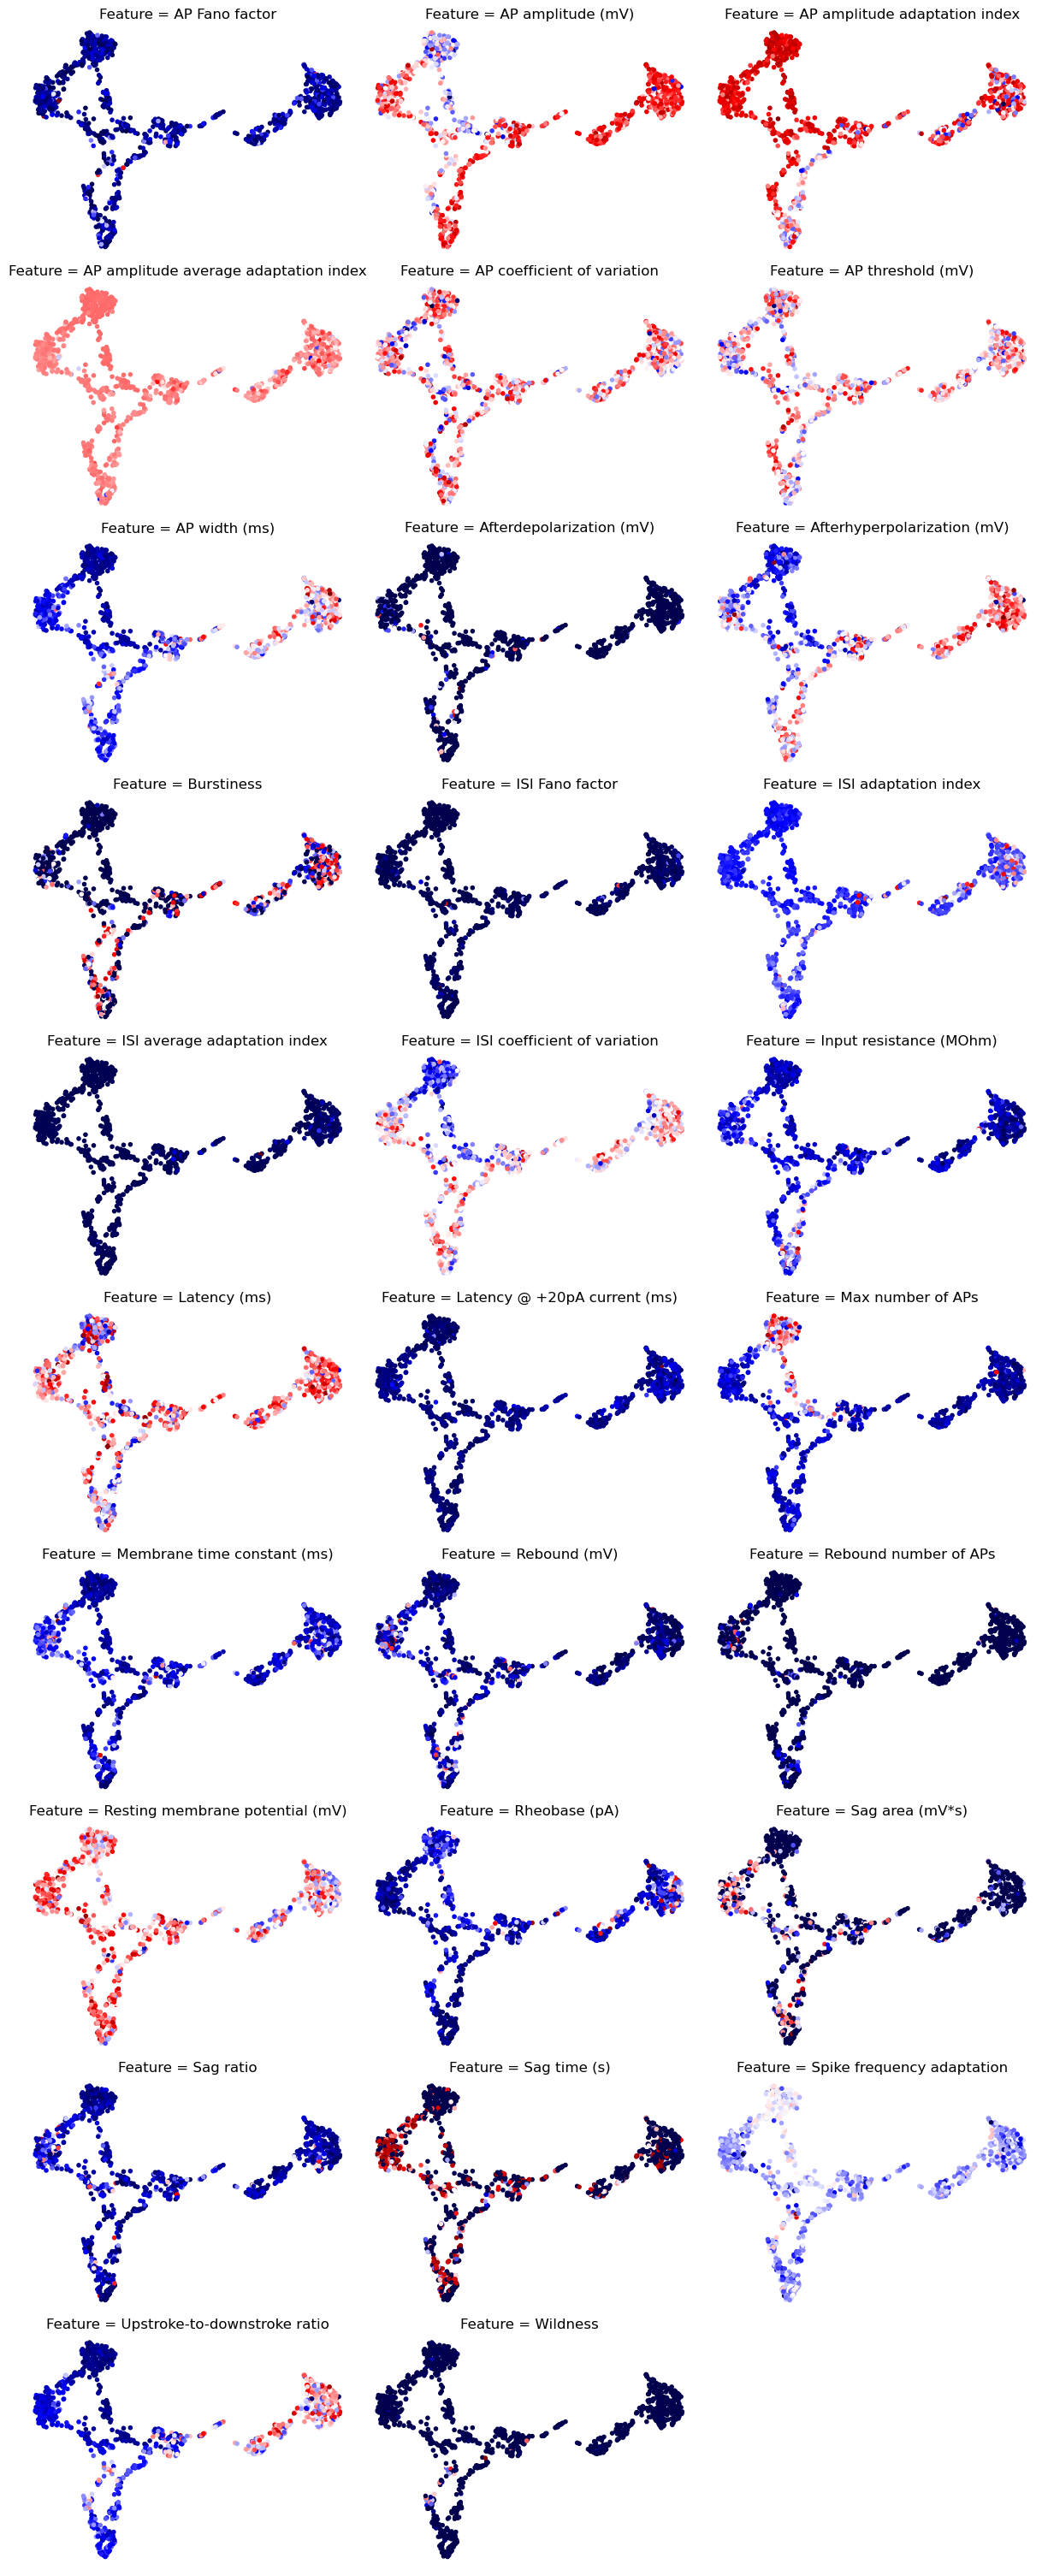

In [460]:
fig, axes = plt.subplots(10, 3, figsize=(12, 30))
axes_flat = np.ravel(axes)

umap_model = umap.UMAP(random_state=7)
umap_results = umap_model.fit_transform(pca_result)

for idx in range(0, len(axes_flat)):
    if idx == 29:
        break
    ax = axes_flat[idx]
    x = X[:, idx]
    norm = Normalize(vmin=min(x), vmax=max(x))
    colors = plt.cm.seismic(norm(x))

    ax.scatter(umap_results[:, 0], umap_results[:, 1], c=colors)
    ax.set_title(
        f"Feature = {ephysNames[idx]}",
        fontsize=12,
    )
    ax.axis("off")
axes_flat[29].axis("off")
plt.show()

## 4) Clustering ##

In [461]:
import igraph as ig
from sklearn.neighbors import kneighbors_graph
import leidenalg as la
from sklearn.cluster import HDBSCAN
from sklearn.mixture import GaussianMixture

print(f"Amount of Clusters in Original Data: {len(np.unique(cluster_colors))}")

Amount of Clusters in Original Data: 78


In [462]:
clusterCols = [
    "#FFFF00",
    "#1CE6FF",
    "#FF34FF",
    "#FF4A46",
    "#008941",
    "#006FA6",
    "#A30059",
    "#FFDBE5",
    "#7A4900",
    "#0000A6",
    "#63FFAC",
    "#B79762",
    "#004D43",
    "#8FB0FF",
    "#997D87",
    "#5A0007",
    "#809693",
    "#FEFFE6",
    "#1B4400",
    "#4FC601",
    "#3B5DFF",
    "#4A3B53",
    "#FF2F80",
    "#61615A",
    "#BA0900",
    "#6B7900",
    "#00C2A0",
    "#FFAA92",
    "#FF90C9",
    "#B903AA",
    "#D16100",
    "#DDEFFF",
    "#000035",
    "#7B4F4B",
    "#A1C299",
    "#300018",
    "#0AA6D8",
    "#013349",
    "#00846F",
    "#372101",
    "#FFB500",
    "#C2FFED",
    "#A079BF",
    "#CC0744",
    "#C0B9B2",
    "#C2FF99",
    "#001E09",
    "#00489C",
    "#6F0062",
    "#0CBD66",
    "#EEC3FF",
    "#456D75",
    "#B77B68",
    "#7A87A1",
    "#788D66",
    "#885578",
    "#FAD09F",
    "#FF8A9A",
    "#D157A0",
    "#BEC459",
    "#456648",
    "#0086ED",
    "#886F4C",
    "#34362D",
    "#B4A8BD",
    "#00A6AA",
    "#452C2C",
    "#636375",
    "#A3C8C9",
    "#FF913F",
    "#938A81",
    "#575329",
    "#00FECF",
    "#B05B6F",
    "#8CD0FF",
    "#3B9700",
    "#04F757",
    "#C8A1A1",
    "#1E6E00",
    "#7900D7",
    "#A77500",
    "#6367A9",
    "#A05837",
    "#6B002C",
    "#772600",
    "#D790FF",
    "#9B9700",
    "#549E79",
    "#FFF69F",
    "#201625",
    "#72418F",
    "#BC23FF",
    "#99ADC0",
    "#3A2465",
    "#922329",
    "#5B4534",
    "#FDE8DC",
    "#404E55",
    "#0089A3",
    "#CB7E98",
    "#A4E804",
    "#324E72",
    "#6A3A4C",
    "#83AB58",
    "#001C1E",
    "#D1F7CE",
    "#004B28",
    "#C8D0F6",
    "#A3A489",
    "#806C66",
    "#222800",
    "#BF5650",
    "#E83000",
    "#66796D",
    "#DA007C",
    "#FF1A59",
    "#8ADBB4",
    "#1E0200",
    "#5B4E51",
    "#C895C5",
    "#320033",
    "#FF6832",
    "#66E1D3",
    "#CFCDAC",
    "#D0AC94",
    "#7ED379",
    "#012C58",
]

In [463]:
### Leiden
A = kneighbors_graph(data_final, 15)
sources, targets = A.nonzero()
A = ig.Graph(zip(sources, targets))

In [474]:
pca_result = sklearn.decomposition.PCA(n_components=50).fit_transform(
    data_final
)
tsne = sklearn.manifold.TSNE(n_components=2, perplexity=30, random_state=7)
tsne_results = tsne.fit_transform(pca_result)

0.6950000000000005


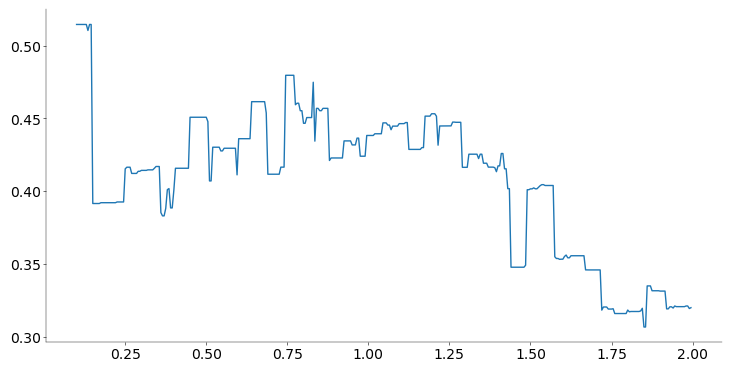

In [477]:
resolutions = np.arange(0.1, 2, 0.005)
L = []
for resolution in resolutions:
    partition = la.find_partition(
        A, la.RBConfigurationVertexPartition, resolution_parameter=resolution
    )
    sil_score = sklearn.metrics.silhouette_score(
        tsne_results, partition.membership
    )
    L.append(sil_score)
print(resolutions[np.argmax(L[10:])])
plt.plot(resolutions, L)
plt.show()

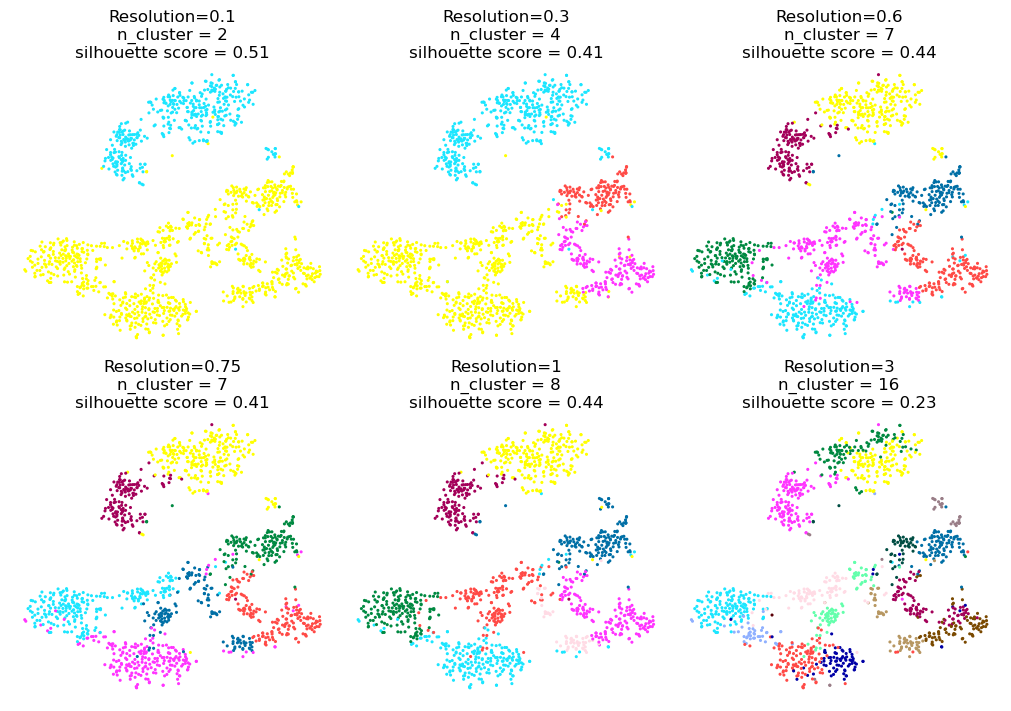

In [476]:
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
axes_flat = np.ravel(axes)
resolutions = [0.1, 0.3, 0.6, 0.75, 1, 3]
for idx, resolution in enumerate(resolutions):
    ax = axes_flat[idx]
    partition = la.find_partition(
        A, la.RBConfigurationVertexPartition, resolution_parameter=resolution
    )
    sil_score = sklearn.metrics.silhouette_score(
        tsne_results, partition.membership
    )
    ax.scatter(
        tsne_results[:, 0],
        tsne_results[:, 1],
        c=np.array(clusterCols)[partition.membership],
        s=6,
    )
    ax.set_title(
        f"Resolution={resolution}\nn_cluster = {len(np.unique(partition.membership))}\nsilhouette score = {sil_score:.2f}"
    )
    ax.axis("off")
plt.show()

## To Dos

- Inspect the data schön machen
- 2)3) Different transforms for the 2d Visualization
- 3) Quantitative measures for tsne and umap
- den Rest